In [1]:
import pickle
import numpy as np
import pandas as pd
import re
import string
from gensim.parsing.preprocessing import remove_stopwords
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from bs4 import BeautifulSoup
!pip install pyLDAvis

import pyLDAvis
import pyLDAvis.gensim_models


sentdf = pd.read_pickle('sentdf.pkl')

sentdf

,product_parent,discipline,review_body,review_date,star_rating,sentiment
0,598678717,psychology,Review based on a cursory examination by Unive...,2005-10-14,4,4
1,697870179,economy,ALthough he is correct that the IMF and World ...,2005-10-14,3,3
2,339619920,politics,While I don't always agree with his TV analysi...,2005-10-14,2,2
3,733918058,economy,Since the 1992 presidential run of H. Ross Per...,2005-10-14,4,4
4,82232603,economy,In terms of programming concepts and OOP desig...,2005-10-14,5,3
...,...,...,...,...,...,...
42466,218513537,politics,This book captures the reality of the American...,1996-05-19,5,5
42467,426467516,psychology,"Based on anecdotal evidence, intuition, tradit...",1996-05-15,5,4
42468,232298383,politics,An excellent monograph by an outstanding scholar,1995-11-19,5,5
42469,323732312,politics,The authors write with clarity in a field whic...,1995-09-14,4,4


In [2]:
from nltk.probability import FreqDist

# function to plot most frequent terms
def freq_words(x, terms = 30):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()

  fdist = FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top 20 most frequent words
  d = words_df.nlargest(columns="count", n = terms) 
  plt.figure(figsize=(20,5))
  ax = sns.barplot(data=d, x= "word", y = "count")
  ax.set(ylabel = 'Count')
  plt.show()

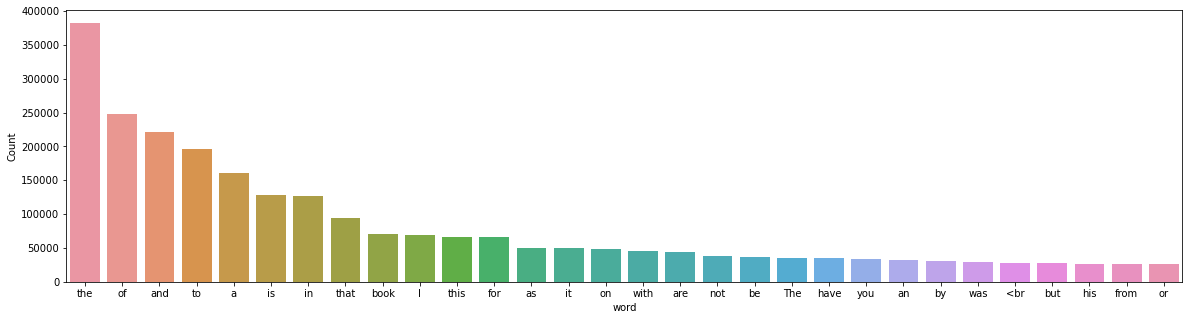

In [3]:
from matplotlib import pyplot as plt
import seaborn as sns
freq_words(sentdf['review_body'])

In [4]:
# remove unwanted characters, numbers and symbols 
sentdf['review_body'] = sentdf['review_body'].str.replace("[^a-zA-Z#]", " ")

from nltk.corpus import stopwords 
stop_words = stopwords.words('english')

# function to remove stopwords 
def remove_stopwords(rev):     
  rev_new = " ".join([i for i in rev if i not in stop_words])      
  return rev_new 

# remove short words (length < 3) 
sentdf['review_body'] = sentdf['review_body'].apply(lambda x: ' '.join([w for 
                   w in x.split() if len(w)>2])) 

# remove stopwords from the text 
reviews = [remove_stopwords(r.split()) for r in sentdf['review_body']] 

# make entire text lowercase 
reviews = [r.lower() for r in reviews]

C:\Users\ibrah\AppData\Local\Temp/ipykernel_14032/3426351183.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  sentdf['review_body'] = sentdf['review_body'].str.replace("[^a-zA-Z#]", " ")


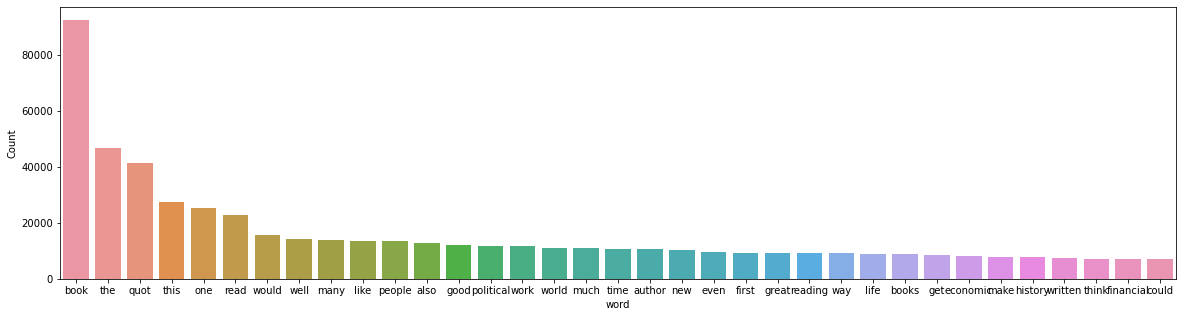

In [5]:
freq_words(reviews, 35)

In [8]:
import spacy

nlp = spacy.load("en_core_web_sm",disable=['parser', 'ner'])

def lemmatization(texts, tags=['NOUN', 'ADJ']): 
       output = []        
       for sent in texts:              
             doc = nlp(" ".join(sent))                             
             output.append([token.lemma_ for token in doc if 
             token.pos_ in tags])        
       return output

In [9]:
tokenized_reviews = pd.Series(reviews).apply(lambda x: x.split())
print(tokenized_reviews[1])

['although', 'correct', 'imf', 'world', 'bank', 'play', 'role', 'also', 'advocate', 'reforming', 'institutions', 'reflect', 'interest', 'dominant', 'capitalist', 'countries', 'politics', 'role', 'well', 'must', 'address', 'inherent', 'contradictions', 'within', 'capitalist', 'system', 'encourages', 'capital', 'accumulation', 'flight', 'waste', 'all', 'interesting', 'read', 'insider', 'looking', 'alternatives', 'washington', 'consensus', 'book', 'this', 'book', 'mainly', 'advocates', 'tweeking', 'international', 'system', 'imf', 'world', 'bank', 'help', 'alleviate', 'poverty', 'political', 'well', 'economic', 'reasons', 'changing', 'per', 'would', 'hoped', 'would', 'taken', 'capitalist', 'world', 'system', 'predictable', 'modern', 'expression', 'future', 'trajectory']


In [19]:
reviews_2 = lemmatization(tokenized_reviews)
print(reviews_2[1]) # print lemmatized review

  0%|          | 0/42470 [06:12<?, ?it/s]

['correct', 'play', 'role', 'institution', 'interest', 'dominant', 'capitalist', 'country', 'politics', 'role', 'inherent', 'contradiction', 'capitalist', 'system', 'capital', 'accumulation', 'flight', 'waste', 'interesting', 'read', 'insider', 'alternative', 'book', 'international', 'system', 'help', 'poverty', 'political', 'economic', 'reason', 'capitalist', 'world', 'system', 'predictable', 'modern', 'expression', 'future', 'trajectory']


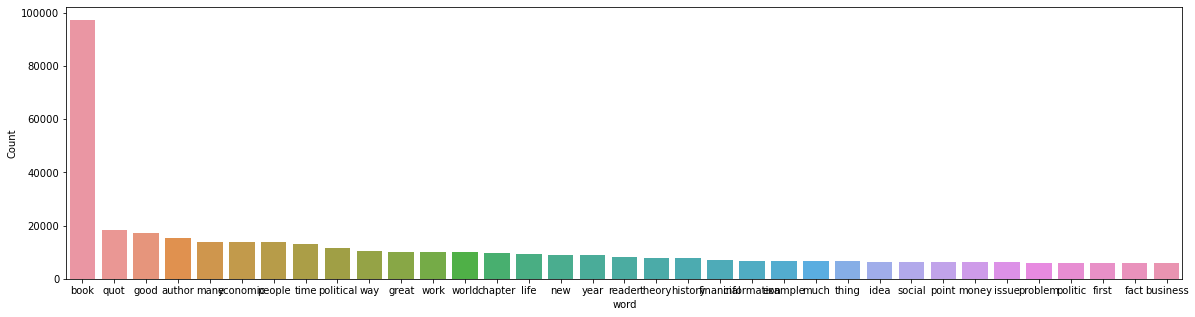

In [21]:
reviews_3 = []
for i in range(len(reviews_2)):
  reviews_3.append(' '.join(reviews_2[i]))

sentdf['review_body'] = reviews_3

freq_words(sentdf['review_body'], 35)

In [23]:
from gensim import corpora
dictionary = corpora.Dictionary(reviews_2)

In [31]:
# !pip install gensim
import gensim
from gensim import models
from gensim import corpora
import pyLDAvis.gensim_models
LDA = gensim.models.ldamodel.LdaModel

In [32]:
doc_term_matrix = [dictionary.doc2bow(rev) for rev in reviews_2]

# Creating the object for LDA model using gensim library 
LDA = gensim.models.ldamodel.LdaModel 

# Build LDA model 
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary,                                     
                num_topics=7, random_state=100, chunksize=1000,                                     
                passes=50)

In [34]:
lda_model.print_topics()

[(0,
  '0.019*"economy" + 0.016*"economic" + 0.013*"business" + 0.013*"world" + 0.012*"market" + 0.011*"new" + 0.010*"policy" + 0.010*"system" + 0.007*"country" + 0.007*"technology"'),
 (1,
  '0.070*"economic" + 0.031*"theory" + 0.018*"model" + 0.014*"economist" + 0.012*"chapter" + 0.012*"analysis" + 0.011*"market" + 0.009*"text" + 0.008*"datum" + 0.007*"problem"'),
 (2,
  '0.029*"woman" + 0.022*"life" + 0.016*"man" + 0.013*"child" + 0.012*"human" + 0.011*"people" + 0.009*"self" + 0.008*"gender" + 0.008*"family" + 0.007*"black"'),
 (3,
  '0.025*"political" + 0.014*"politic" + 0.010*"right" + 0.010*"government" + 0.010*"war" + 0.010*"american" + 0.008*"state" + 0.007*"medium" + 0.007*"country" + 0.007*"power"'),
 (4,
  '0.091*"book" + 0.058*"quot" + 0.015*"good" + 0.014*"author" + 0.013*"time" + 0.011*"people" + 0.009*"many" + 0.009*"way" + 0.009*"thing" + 0.008*"great"'),
 (5,
  '0.025*"book" + 0.014*"work" + 0.013*"social" + 0.012*"history" + 0.010*"study" + 0.010*"political" + 0.009*

In [37]:
# Visualize the topics 
pyLDAvis.enable_notebook() 
vis = pyLDAvis.gensim_models.prepare(lda_model, doc_term_matrix,  
                              dictionary) 
vis

C:\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.111175  0.226583       1        1  21.452779
6      0.159345  0.094294       2        1  19.967380
5      0.088527 -0.017154       3        1  16.507226
3     -0.185948 -0.022911       4        1  15.284412
0     -0.097349 -0.179978       5        1  10.943946
2     -0.239339  0.109158       6        1   9.433247
1      0.163588 -0.209992       7        1   6.411010, topic_info=            Term          Freq         Total Category  logprob  loglift
0           book  99411.000000  99411.000000  Default  30.0000  30.0000
8311        quot  29405.000000  29405.000000  Default  29.0000  29.0000
30      economic  14756.000000  14756.000000  Default  28.0000  28.0000
793       theory   8124.000000   8124.000000  Default  27.0000  27.0000
43     political  12635.000000  12635.000000  Default  26.0000  26.0000
...          ...           ...           ...      ...      ...      ...
181        level    718.808012   3179.085318   Topic7  -5.3457   1.2604
177         good    951.352602  17452.545535   Topic7  -5.0654  -0.1622
202       author    857.339214  14750.351998   Topic7  -5.1695  -0.0980
15        reader    753.864113   8501.655168   Topic7  -5.2981   0.3243
82    discussion    635.248309   2615.612160   Topic7  -5.4693   1.3319

[490 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
830        1  0.106890    academic
830        2  0.057447    academic
830        3  0.724213    academic
830        7  0.111128    academic
554        2  0.998879  accounting
...      ...       ...         ...
439        3  0.013845        year
439        4  0.188246        year
439        5  0.084521        year
439        6  0.076035        year
24689      3  0.997179      yeoman

[889 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 7, 6, 4, 1, 3, 2])